In this notebook, I will work on part 2 of the image stitching series. Between this post and the [previous post](http://learningjulia.com/2017/03/26/image-stitching-part-1.html), I go through all 7 steps of an image stitching pipeline:

1. Extracting feature points (_Part 1_)
2. Calculate descriptors (_Part 1_)
3. Match points (_Part 1_)
4. Calculate transformation (_Part 2_)
5. Transforming the image (_Part 2_)
6. Using RANSAC to improve transformation computation (_Part 2_)
7. Stitch images (_Part 2_)

In this notebook, I'll go through Part 2: calculating a transformation and actually stitching the images together. In the course of writing this post, I learned all about [OffsetArrays](https://github.com/JuliaArrays/OffsetArrays.jl/blob/master/src/OffsetArrays.jl) and how they can be useful for image processing in Julia!

In [1]:
using ImageFeatures, Images, FileIO, ImageDraw;

I'll use the same two images I used in the previous post, two images of the Stata Center in Cambridge, MA. At the end of the post, we'll stitch them together in one large image.

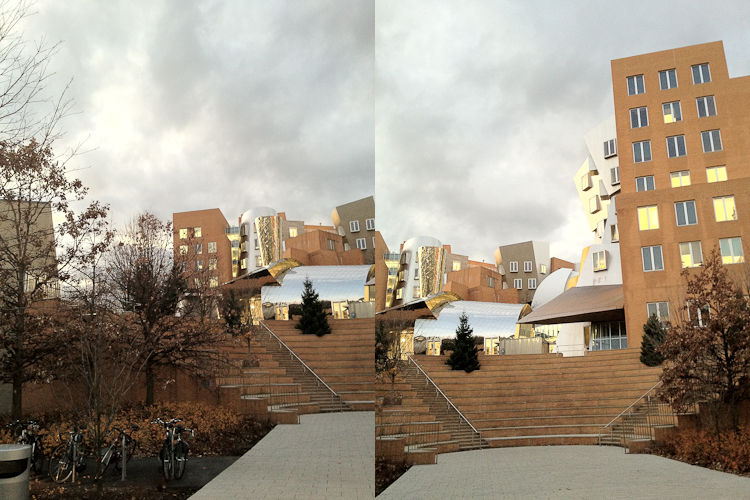

In [2]:
img1 = load("imgs/stata-1.png")
img2 = load("imgs/stata-2.png")
[img1 img2]

To recap steps 1 through 3 from the previous post, we extracted feature points, calculated feature descriptors, and matched the points together. I'm going to copy over the `get_descriptors` and `match_points` functions directly. 

In [47]:
function get_descriptors(img::AbstractArray)
    imgp = parent(img)
    brisk_params = BRISK()
    features = Features(Keypoints(imcorner(imgp, method=harris)))
    desc, ret_features = create_descriptor(Gray.(imgp), features, brisk_params)
end

function match_points(img1::AbstractArray, img2::AbstractArray, threshold::Float64=0.1)
    img1p = parent(img1)
    img2p = parent(img2)
    desc_1, ret_features_1 = get_descriptors(img1p)
    desc_2, ret_features_2 = get_descriptors(img2p)
    matches = match_keypoints(
        Keypoints(ret_features_1), Keypoints(ret_features_2),
        desc_1, desc_2, threshold)
end

match_points (generic function with 2 methods)

But, I'm going to modify my `draw_matches` functions slightly. It might be the case that we want to match points between two images that are different vertical sizes. To make this happen, we will first need to put both images on the same canvas. To do this, I'm going to make a `pad_display` function and update my `draw_matches` function to use it. I in fact figured out that I needed this modification much later in the process of creating this post, but the beauty of Jupyter notebooks is that I can do back and edit things as I need, and use them later.

In [4]:
# this function takes the two images and concatenates them horizontally.
# to horizontally concatenate, both images need to be made the same
# vertical size
function pad_display(img1, img2)
    img1h = length(indices(img1, 1))
    img2h = length(indices(img2, 1))
    mx = max(img1h, img2h);
    hcat(vcat(img1, zeros(RGB{Float64},
                max(0, mx - img1h), length(indices(img1, 2)))),
        vcat(img2, zeros(RGB{Float64},
                max(0, mx - img2h), length(indices(img2, 2)))))
end

function draw_matches(img1, img2, matches)
    # instead of having grid = [img1 img2], we'll use the new
    # pad_display() function
    grid = pad_display(parent(img1), parent(img2));
    offset = CartesianIndex(0, size(img1, 2));
    for m in matches
        draw!(grid, LineSegment(m[1], m[2] + offset))
    end
    grid
end

draw_matches (generic function with 1 method)

Let's make sure it all works!

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] one(::Type{ColorTypes.RGB{Float64}}) at /home/mprat/.julia/v0.6/ColorVectorSpace/src/ColorVectorSpace.jl:356
 [3] draw! at /home/mprat/.julia/v0.6/ImageDraw/src/line2d.jl:64 [inlined] (repeats 2 times)
 [4] draw_matches(::Array{ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}},2}, ::Array{ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}},2}, ::Array{Array{CartesianIndex{2},1},1}) at ./In[4]:18
 [5] include_string(::String, ::String) at ./loading.jl:515
 [6] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/mprat/.julia/v0.6/IJulia/src/execute_request.jl:180
 [7] (::Compat.#inner#14{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/mprat/.julia/v0.6/Compat/src/Compat.jl:332
 [8] eventloop(::ZMQ.Socket) at /home/mprat/.julia/v0.6/IJulia/src/eventloop.jl:8
 [9] (::IJulia.##15#18)() at ./task.jl:335
while loading In[26], in expression starting on line 2


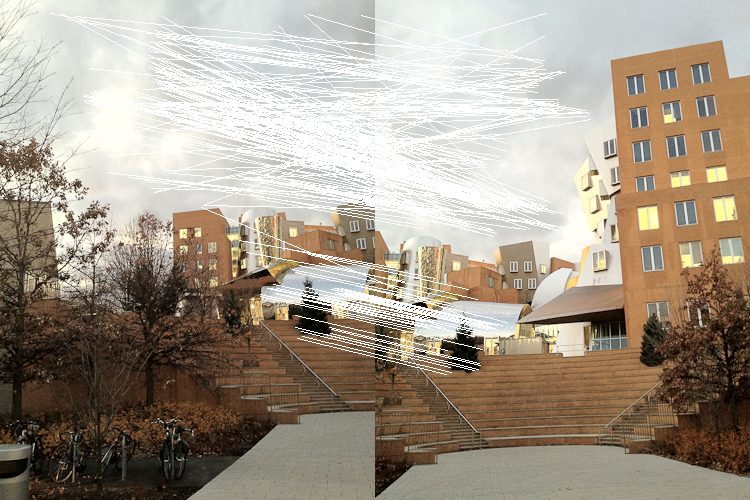

In [26]:
matches = match_points(img1, img2, 0.08);
draw_matches(img1, img2, matches)

*Note that the `draw_matches` function throws a warning that comes from the `ImageDraw` package. Right now we're just going to ignore this warning, but hopefully in a future notebook I can figure out how to fix it!*

# Calculate Transformation

Now that we've found the pairs of pixels that correspond between the two images, we can use those matches to find a matrix that describes the transformation from one image to another. We can then use this transformation to warp one of the images and do the stitching.

To calculate the transformation from one image to another, we compute a transformation called a **homography**. It is based on the "pinhole camera assumption", where the same scene taken from the same camera is related by rotation, translation, and skew. [This OpenCV tutorial](https://docs.opencv.org/3.4.1/d9/dab/tutorial_homography.html) has a good, practical example of homography estimation with some geometric examples.

A homography matrix has 8 free parameters - this means that with 4 pairs of matched points in our image, we can compute a homography that describes how to transform from the first set to the second set of points.

Usually, I am a fan of reusing someone else's code that is well-written, but in this case I had to take matters into my own hands.

The [ImageProjectiveGeometry](https://github.com/peterkovesi/ImageProjectiveGeometry.jl) package implements a homography filling algorithm, but the package was built for Julia 0.4 and I had a hard time getting to play nice with my Julia 0.6 environment. Instead, I am going to write my own code for this in Julia.

My homography function is going to take some `matches` returned from our descriptor matching function; as a reminder, `matches` is returned as an array of `Keypoints`.

To make our homography computation easier, we will create a new type (with the `immutable` keyword) that is a 3 x 3 matrix, that is also a subtype of an `AbstractAffineMap` from the [CoordinateTransformations](https://github.com/FugroRoames/CoordinateTransformations.jl) package. We do this because the `CoordinateTransformations` package has a `warp` function that can be used to apply this transformation (i.e. homography) to images, without having to write our own projection code.

In [6]:
using CoordinateTransformations, StaticArrays, ImageTransformations;

In [7]:
immutable Homography{T} <: AbstractAffineMap
    m::SMatrix{3, 3, T, 9}
end

# having T in the RHS forces calling the constructor again
Homography{T}(m::AbstractMatrix{T}) = Homography{T}(m);

Now that we've set up the homography data type, we can actually write the function that will compute the homography. We want to apply it to an array if `Keypoints` that we previously computed (and matched).

There are typically 2 ways in which a homography is computed:
1. "Exactly", using 4 pairs of points. Because there are 9 unknowns in the homography matrix (one of which we always set to 1, so it's really 9 up to a scale factor), we can solve an exact system of linear equations with 4 pairs of points to get the exact homography between the pairs. Each pair of points creates 2 linear equations, so with 4 pairs of points you get 8 equations, which is enough to determine an exact solution (up to a scale factor, since we want the bottom-right entry in the homography matrix to be 1).
2. Using the "least-squares" method. With more than 4 pairs of points, your system equations is overconstrained, so you need to find the best "average" homography that fits all the pairs.

To set up the system of equations to compute a homography, we set up a a system of equations as follows: knowing that a homography relates two points $u$ and $v$ in 3D space by $v = H u \rightarrow H u - v = 0$, which is  homogenous linear equation of the form $A x = 0$ (with some clever re-arranging of the coefficients). Because we deal with 2D points (i.e. locations in an image), the 3rd dimension of $u$ and $v$ is always 1. With a little bit of algebraic manipulation you get that each pair of points contributes these 2 equations to the matrix $A$:

\begin{equation}
H u - v = 0
\end{equation}

\begin{equation}
\begin{bmatrix}
h_1 & h_2 & h_3 \\
h_4 & h_5 & h_6 \\
h_7 & h_8 & h_9
\end{bmatrix}\begin{bmatrix}
u_1 \\ u_2 \\ 1
\end{bmatrix}
-
\begin{bmatrix}
v_1 \\ v_2 \\ 1
\end{bmatrix} = 0
\end{equation}

\begin{equation}
\begin{bmatrix}
0 & 0 & 0 & -u_1 & -u_2 & 1 & v_2 u_1 & v_2 u_2 & v_2 \\
u_1 & u_2 & 1 & 0 & 0 & 0 & -v_1 u_1 & -v_1 u_2 & -v_1
\end{bmatrix}\begin{bmatrix}
h_1 \\ h_2 \\ h_3 \\ h_4 \\ h_5 \\ h_6 \\ h_7 \\ h_8 \\ h_9
\end{bmatrix} = 0
\end{equation}

\begin{equation}
A x = 0
\end{equation}

When we have more points, we just have more instances of the pair of equations on the left-hand side in Equation (3), with the same homography-matrix-as-a-column-vector on the right.

The good news is that in both cases (exact solution & least-squares estimation), we can use the same method: applying singular value decomposition (SVD) on the resulting equation matrix $A$ and take the smallest eigenvector. When do this with only 4 points, you get the exact solution to the system of equations.

My `compute_homography` function below re-creates this linear system of equations and solves it using SVD.

In [30]:
function compute_homography(matches::Array{Keypoints})
    # eigenvector of A^T A with the smallest eigenvalue
    
    # construct A matrix
    A = zeros(2 * length(matches), 9)
    for (index, match) in enumerate(matches)
        match1, match2 = match
        base_index_x = index * 2 - 1
        base_index_y = 1:3
        A[base_index_x, base_index_y] = float([match1.I...; 1;])
        A[base_index_x + 1, 4:6] = A[base_index_x, base_index_y]
        A[base_index_x, 7:9] =
            -1.0 * A[base_index_x, base_index_y] * match2.I[1]
        A[base_index_x + 1, 7:9] =
            -1.0 * A[base_index_x, base_index_y] * match2.I[2]
    end
  
    A
    # find the smallest eigenvector, normalize, and reshape
    U, S, Vt = svd(A)
    
    # normalize the homography at the end, since we know the (3, 3)
    # entry should be 1.
    Homography(reshape(Vt[:, end] ./ Vt[end][end], (3, 3))')
end

compute_homography (generic function with 1 method)

*As an aside, I learned about multi-line commands in Julia. Take for instance line 12 in the `compute_homography` function above. It was too long to read on the blog, so I split it up into multiple lines. Julia will ignore all whitespace (and look at the next line for command input) until it finds a complete command. So you can put any whitespace you want in your Julia code. I like to keep it ~80 characters per line, for easy readability.*

Now that we've computed the homography, we want to actually apply it to points that we got from the image.

Because a homography is a 3x3 matrix, it is applied to  a point in 3D space. However, if we want to apply it to a point in 2D space (like for example, the point $(1, 1)$, which is the image origin), we need to append $1.0$ as the last element.

The output of a homography transformation is always a point in 2D space, so we need to transform the result of the homography from a 3D coordinate to a normalized 2D coordinate. We take advantage of Julia's multiple dispatch (i.e. calling of methods based on the types of the arguments) to make a bunch of utility methods that override the `()` operator and take care of this 3D / 2D conversion for us.

In [27]:
# these 5 functions override the () operator, so we can
# do something like H(image) and have H (the homography)
# be applied to the image, SVector{2}, cartesian index,
# or tuple.
function (trans::Homography{M}){M}(x::SVector{3})
    out = trans.m * x;
    out = out / out[end];
    SVector{2}(out[1:2])
end

function (trans::Homography{M}){M}(x::SVector{2})
    trans(SVector{3}([x[1], x[2], 1.0]))
end

function (trans::Homography{M}){M}(x::CartesianIndex{2})
    trans(SVector{3}([collect(x.I); 1]))
end

function (trans::Homography{M}){M}(x::Tuple{Int, Int})
    trans(CartesianIndex{2}(x))
end

function (trans::Homography{M}){M}(x::Array{CartesianIndex{2}, 1})
    CartesianIndex{2}.([tuple(y...) for y in trunc.(Int, collect.(trans.(x)))])
end

# we need to override the inverse function on our homography
function Base.inv(trans::Homography)
    i = inv(trans.m);
    Homography(i ./ i[end])
end

Let's test our homography function (and the displaying of the result) on a simple transformation we apply on our "wild" test images from above.

Using the `CoordinateTransformations` package, let's rotate one of our images a little it. Because we know the absolute transformation (a rotation), we can write it in terms of a homography and test that our `compute_homography` function works as expected.

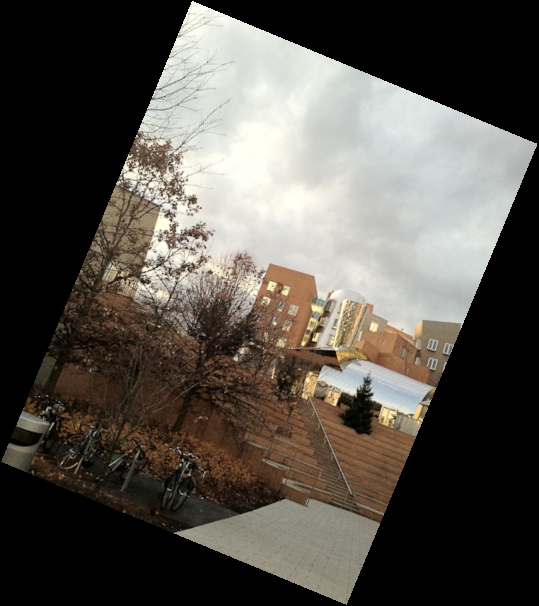

In [10]:
rotation = LinearMap(RotMatrix(pi/8));
img1rot = warp(img1, rotation)

## Transform Image

Now that we have a homography (transformation) matrix, we need to apply the homography to each pixel in the first image. This will assign a new location to each pixel, effectively warping the original image into the same "space" as the second image.

A homography transforms an image into a new space. The inverse (i.e. the matrix inverse) of the homography transforms the transformed image back into the original image. To see what that's like, let's warp the rotated image by the inverse of the rotation.

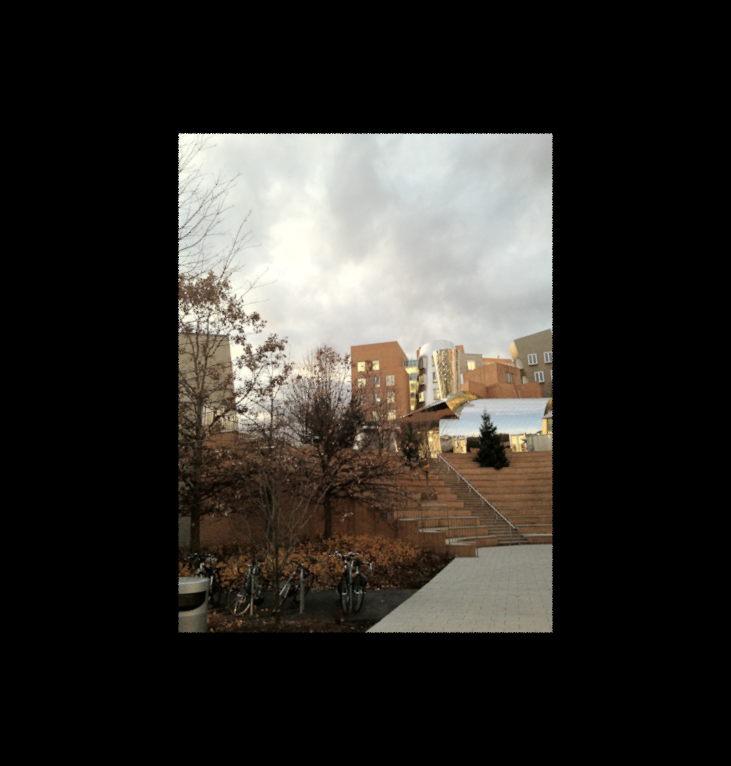

In [11]:
out = warp(img1rot, inv(rotation))

The type of the output image is an OffsetArray - a type that we'll look at later.

In [12]:
typeof(out)

OffsetArrays.OffsetArray{ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}},2,Array{ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}},2}}

Let's use this simple rotated image to test our maching and homography computation code by computing the homography, drawing the two images side by side, and drawing the point matches. In the ideal case, we want the computed homography from our `compute_homography` function to exactly find the rotation.

The first step is to find the matches between the image and the rotated image.

In [13]:
matches_rot = match_points(img1, img1rot, 0.07);

Let's visualize all the matches we got and see what happens:

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] one(::Type{ColorTypes.RGB{Float64}}) at /home/mprat/.julia/v0.6/ColorVectorSpace/src/ColorVectorSpace.jl:356
 [3] draw! at /home/mprat/.julia/v0.6/ImageDraw/src/line2d.jl:64 [inlined] (repeats 2 times)
 [4] draw_matches(::Array{ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}},2}, ::OffsetArrays.OffsetArray{ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}},2,Array{ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}},2}}, ::Array{Array{CartesianIndex{2},1},1}) at ./In[4]:18
 [5] include_string(::String, ::String) at ./loading.jl:515
 [6] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/mprat/.julia/v0.6/IJulia/src/execute_request.jl:180
 [7] (::Compat.#inner#14{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/mprat/.julia/v0.6/Compat/src/Compat.jl:332
 [8] eventloop(::ZMQ.Socket) at /home/mprat/.julia/v0.6/IJulia/src/eventloop.jl:8
 [9] (::IJulia.##15#18)() at ./task.jl:335
while loadi

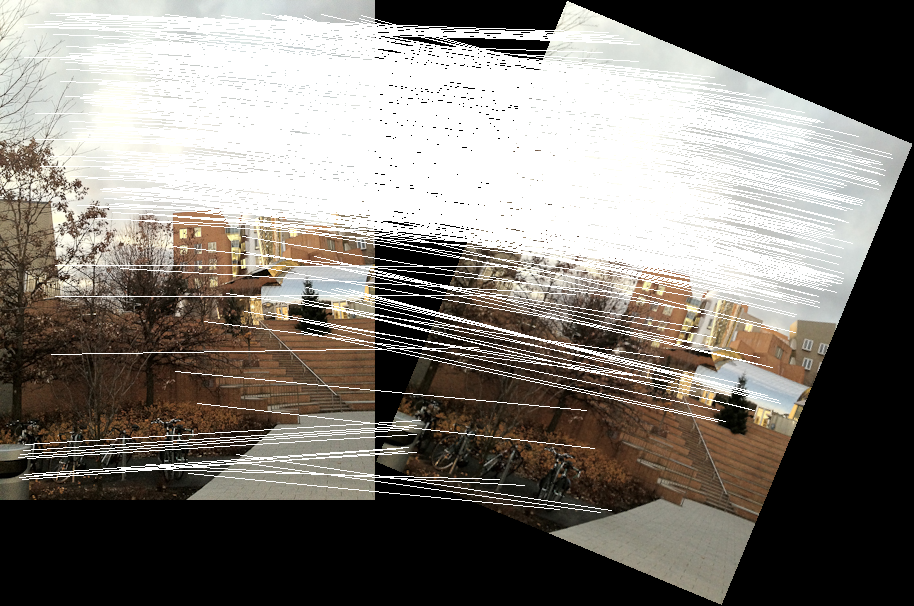

In [28]:
draw_matches(img1, img1rot, matches_rot)

Looks great! We seem to have matched the points in this image pretty nicely (except for whatever happens with the sky). Let's see if we get the same luck with our computed homography!

In [31]:
H_computed_rot = compute_homography(matches_rot)

Homography{Float64}([0.00309203 -0.357604 134.69; -0.573237 -0.544575 299.596; -0.00122728 -0.00230251 1.0])

We can see that the computed homography matrix looks unintuitively strange (it doesn't look like a rotation matrix, if you're used to manipulating those). So instead we will just apply our homography to our image and draw matches between them to visualize.

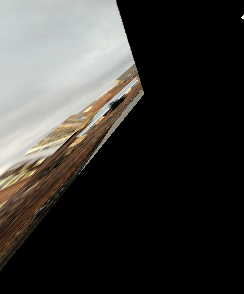

In [32]:
warp(img1rot, H_computed_rot)

Oops, that doesn't look great! Let's finish the last step of homography computation to make this more robust!

## RANSAC: Improving Homography Estimation

The homography computation is a linear estimator. Like all linear estimators, it is not robust to outliers. We got such a bad image above because some of the matches (mostly in the sky) because there were a number of matches that are outliers.

The RANSAC (**RAN**dom **SA**mple **C**onsensus) method of homography estimation was invented to reduce the effect of outliers on the homography computation. The idea is simple: we can compute an exact homography using four random matched points, and see how well those points fit the other matches. The points that fit the matches well are called inliners (as opposed to outliers). Keep doing this for a number of iterations: one of the homographies that fits the point the best (i.e. had those most inliers). Take ALL those points, and recompute a least-squares homography using all those inliers.

Let's get to it!

In [17]:
function apply_ransac(matches, n_iters=20, eps=20)
    best_homography_inliers = []
    best_num_inliers = 0
    
    # for N times, use 8 points to estimate the homography
    for i in 1:n_iters
        # randomly pick 4 points from matches
        matches_sub = rand(matches, 4)

        # calculate the homography
        H_sub = compute_homography(matches_sub)

        # calculate the number of inliers.
        # apply the homography to all the points
        # in the first image. calculate descriptors.
        img1_points = [m[1] for m in matches]
        img2_points = [m[2] for m in matches]
        out = H_sub(img1_points)
        dists = [sqrt(x.I[1]^2 + x.I[2]^2) for x in (out - img2_points)]

        # if diff < epsilon, its an inliner
        inliner_indices = dists .< eps
        num_inliers = sum(inliner_indices)
        
        # if this is the best we got so far, store it
        # and all the inliers
        if num_inliers > best_num_inliers
            best_homography_inliers = matches[inliner_indices]
            best_num_inliers = num_inliers
        end
    end
    
    # calculate the new homography with all the inliers
    H = compute_homography(best_homography_inliers)
end

apply_ransac (generic function with 3 methods)

Now that we have the RANSAC method, we just need to apply it. We've picked an arbitrary number of iterations to make sure we have enough chances to find the right combination of points. Picking the right number of iterations is a bit of a tricky thing, but more is (usually) never worse. Let's go with a few hundred and see where that leaves us.

In [33]:
H_ransac_rot = apply_ransac(matches_rot, 500)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] trunc(::Type{Int64}, ::Array{Float64,1}) at ./deprecated.jl:57
 [3] macro expansion at ./broadcast.jl:153 [inlined]
 [4] macro expansion at ./simdloop.jl:73 [inlined]
 [5] macro expansion at ./broadcast.jl:147 [inlined]
 [6] _broadcast! at ./broadcast.jl:139 [inlined]
 [7] broadcast_t at ./broadcast.jl:268 [inlined]
 [8] broadcast_c at ./broadcast.jl:314 [inlined]
 [9] broadcast at ./broadcast.jl:434 [inlined]
 [10] (::Homography{Float64})(::Array{CartesianIndex{2},1}) at ./In[27]:24
 [11] apply_ransac(::Array{Array{CartesianIndex{2},1},1}, ::Int64, ::Int64) at ./In[17]:18
 [12] apply_ransac(::Array{Array{CartesianIndex{2},1},1}, ::Int64) at ./In[17]:2
 [13] include_string(::String, ::String) at ./loading.jl:515
 [14] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/mprat/.julia/v0.6/IJulia/src/execute_request.jl:180
 [15] (::Compat.#inner#14{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})()

Homography{Float64}([0.920199 0.380142 0.537171; -0.38427 0.918353 192.597; -6.03731e-6 -6.99454e-6 1.0])

Now that looks more like a rotation matrix! Let's take a look!

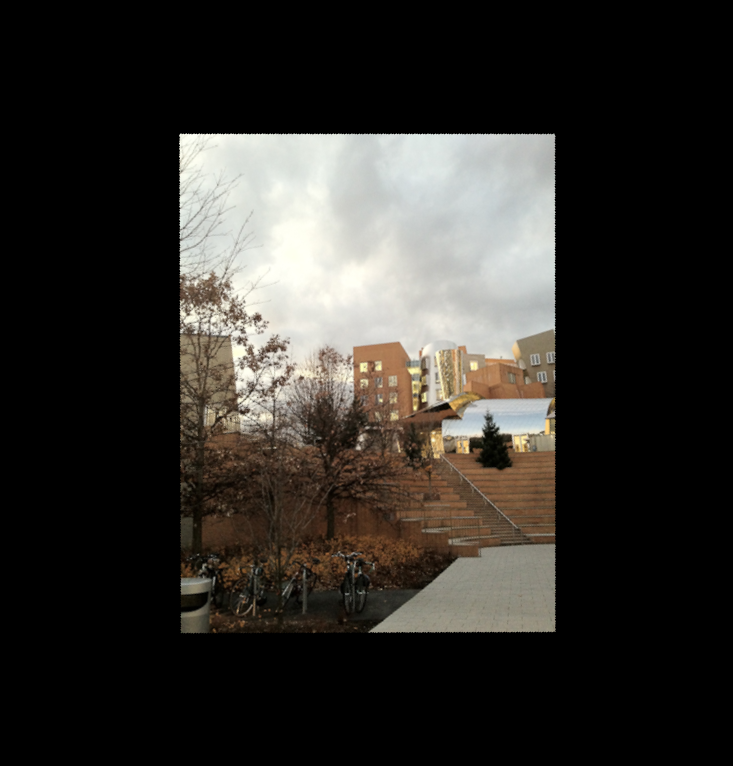

In [34]:
warp(img1rot, H_ransac_rot)

Bam!

Let's see how far we get when we apply what we have so far to the original two images:

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] trunc(::Type{Int64}, ::Array{Float64,1}) at ./deprecated.jl:57
 [3] macro expansion at ./broadcast.jl:153 [inlined]
 [4] macro expansion at ./simdloop.jl:73 [inlined]
 [5] macro expansion at ./broadcast.jl:147 [inlined]
 [6] _broadcast! at ./broadcast.jl:139 [inlined]
 [7] broadcast_t at ./broadcast.jl:268 [inlined]
 [8] broadcast_c at ./broadcast.jl:314 [inlined]
 [9] broadcast at ./broadcast.jl:434 [inlined]
 [10] (::Homography{Float64})(::Array{CartesianIndex{2},1}) at ./In[27]:24
 [11] apply_ransac(::Array{Array{CartesianIndex{2},1},1}, ::Int64, ::Int64) at ./In[17]:18
 [12] apply_ransac(::Array{Array{CartesianIndex{2},1},1}, ::Int64) at ./In[17]:2
 [13] include_string(::String, ::String) at ./loading.jl:515
 [14] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/mprat/.julia/v0.6/IJulia/src/execute_request.jl:180
 [15] (::Compat.#inner#14{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})()

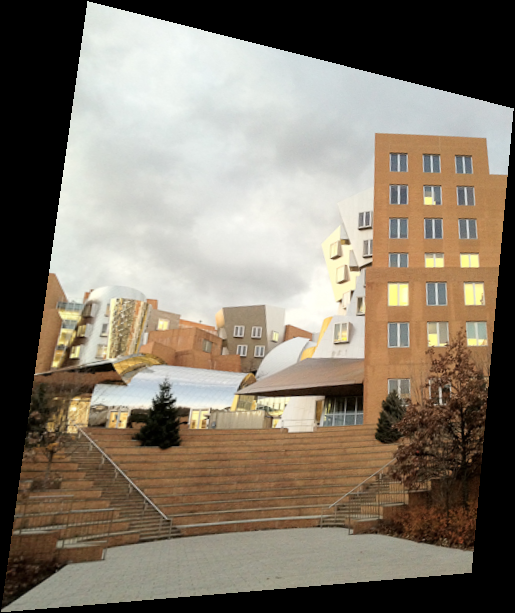

In [39]:
matches = match_points(img1, img2, 0.08)
H_ransac = apply_ransac(matches, 500)
new_img = warp(img2, H_ransac)

Yay! Our homography computation worked! Now, the last step is to merge the images together into a single canvas.

## Merging Images

Now that we have the right transformation (and it looks ok), the last step to stitching the images together in the same canvas.

The idea goes like this: both images we want to merge originally came from the same "coordinate system." A homography describes the geometric relationship between the two images, and that includes translation. So, all we need to do is figure out the translation between the first and second images, create a new image that contains both, and put the pixels from both images into that same canvas.

Now this is where Julia really shines. Remember how the warped image from above is an `OffsetArray`? Like this:

In [40]:
typeof(new_img)

OffsetArrays.OffsetArray{ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}},2,Array{ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}},2}}

We will use this to our advantage when merging images. [OffsetArrays](https://github.com/JuliaArrays/OffsetArrays.jl) are basically arrays, but with arbitrary start and stop indices. So while a "standard" image starts at (0,0) and goes to (1280,720) or something similar, an OffsetArray has the same height and width but might start at (-10, -100).

So how we'll use this is as follows: our new merged image canvas will be an `OffsetArray`. The sizes will be determined by the two images we want to merge (one is an `AbstractArray`, or "regular image" and one is an `OffsetArray`, or "warped image").

_As an aside, I figured out that to find the "offsets" of an `OffsetArray` you use `.start` and `.stop` on the `axes().val` object._

Once we have the dimensions of this new offset array, we are just going to put the original image into it starting at coordinate (1, 1) and ending at the size of the image.

For the merged image, we need to do something a bit more nuanced: because we projected the image into a new space, the places were there was no original pixel from the image became black. In our merging code, we want to ignore these pixels, and only place the non-black pixels into the new canvas. So we iterate through all the pixels (using `indices()` as an iterator, like suggested in the [Julia docs about `OffsetArrays`](https://docs.julialang.org/en/v0.6.2/devdocs/offset-arrays/), and ignore any black pixels.

Once we're one, our resultant new, merged image is an `OffsetArray` that is exactly an image!

In [22]:
using OffsetArrays

In [41]:
function merge_images(img1, new_img)
    axis1_size =
        max(axes(new_img)[1].val.stop, size(img1, 1)) -
        min(axes(new_img)[1].val.start, 1) + 1
    axis2_size =
        max(axes(new_img)[2].val.stop, size(img1, 2)) -
        min(axes(new_img)[2].val.start, 1) + 1
    
    # our new image is an offset array
    combined_image = OffsetArray(
        zeros(RGB{N0f8}, axis1_size, axis2_size), (
            min(0, axes(new_img)[1].val.start),
            min(0, axes(new_img)[2].val.start)))
    
    # we just put the image directly into the new combined canvas
    combined_image[1:size(img1, 1), 1:size(img1, 2)] = img1
    
    # merge all the pixels into the new image that are not black
    for i in indices(new_img, 1)
        for j in indices(new_img, 2)
            if new_img[i, j] != colorant"black"
                combined_image[i, j] = new_img[i, j]
            end
        end
    end
    combined_image
end

merge_images (generic function with 1 method)

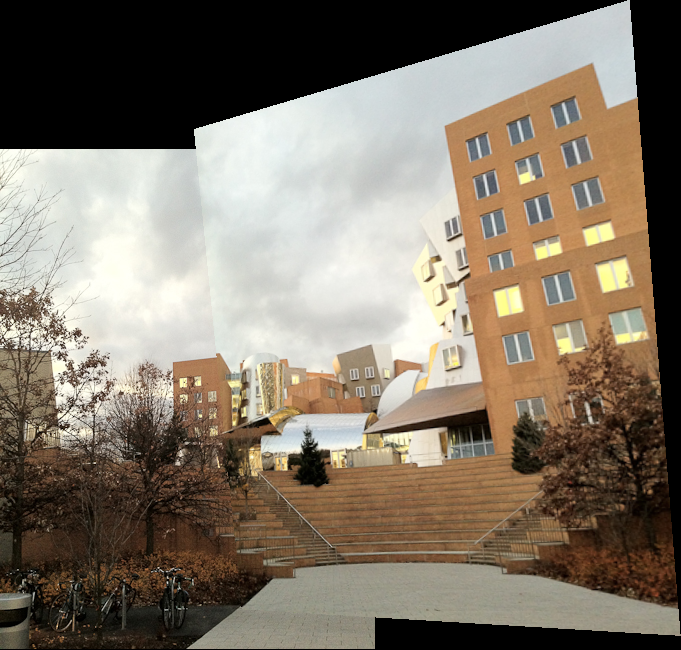

In [45]:
merge_images(img1, new_img)

Voila!

## Conclusion and Summary

Figuring out how to do panomara stitching in Julia was a LOT of fun. It also took me a while, since I had to learn a bunch of new packages and new concepts. But, all together, stiching two images together in Julia is fairly straightforward, and we generate a merged image in the process.

In this investigation I learned a few things:

* How `OffsetArrays` can make merging images insanely easy! (the corresponding code in C++ is complicated because it involves manually finding the size of the new image together with the offsets)
* How multiple dispatch can make applying a homography really easy
* How `StaticArrays` and `CoordinateTransformations` make it easy to apply transformations to images.

The caveat is that I did all of this using Julia 0.6. At the time of this writing, some JuliaImages packages weren't ready for 0.7 and above, but hopefully that will change soon.

I hope someone else learning Julia will find my investigations useful. Thanks for reading, and stay tuned for more!